In [1]:
import pandas as pd
import numpy as np
import os

file_in = "../data/raw/health/child-mortality.csv"
file_out = "../data/interim/child_mortality_clean.csv"


In [2]:
df = pd.read_csv(file_in)
print("Initial shape:", df.shape)
df.head()
df.info()


Initial shape: (16835, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16835 entries, 0 to 16834
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Entity                16835 non-null  object 
 1   Code                  16217 non-null  object 
 2   Year                  16835 non-null  int64  
 3   Child mortality rate  16835 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 526.2+ KB


In [3]:
df = df.rename(columns={
    'Entity': 'country',
    'Code': 'iso_code',
    'Year': 'year',
    'Child mortality rate': 'child_mortality_rate'
})

# drop non-country rows (like regions or aggregates)
df = df[df['iso_code'].notna()]

# keep relevant years for analysis
df = df[df['year'].between(1990, 2022)]

df.head()


,country,iso_code,year,child_mortality_rate
33,Afghanistan,AFG,1990,18.07
34,Afghanistan,AFG,1991,17.44
35,Afghanistan,AFG,1992,16.85
36,Afghanistan,AFG,1993,16.30
37,Afghanistan,AFG,1994,15.77


In [4]:
df['child_mortality_rate'] = pd.to_numeric(df['child_mortality_rate'], errors='coerce')

# replace negative or zero values (invalid)
df.loc[df['child_mortality_rate'] <= 0, 'child_mortality_rate'] = np.nan

# optional: check missing count
print("Missing values:", df['child_mortality_rate'].isna().sum())


Missing values: 0


In [6]:
df = df.sort_values(['iso_code', 'year']).reset_index(drop=True)

df['child_mortality_rate'] = (
    df.groupby('iso_code', group_keys=False)['child_mortality_rate']
      .transform(lambda g: g.interpolate(method='linear', limit_direction='both'))
)

print("After interpolation:", df['child_mortality_rate'].isna().sum(), "missing values remain.")


After interpolation: 0 missing values remain.


In [7]:
# describe stats
print(df['child_mortality_rate'].describe())

# check a few countries
df[df['country'].isin(['Afghanistan','India','Germany'])].head(10)


count    6654.000000
mean        4.551184
std         5.170719
min         0.150000
25%         1.030000
50%         2.370000
75%         6.250000
max        47.890000
Name: child_mortality_rate, dtype: float64


,country,iso_code,year,child_mortality_rate
0,Afghanistan,AFG,1990,18.07
1,Afghanistan,AFG,1991,17.44
2,Afghanistan,AFG,1992,16.85
3,Afghanistan,AFG,1993,16.30
4,Afghanistan,AFG,1994,15.77
5,Afghanistan,AFG,1995,15.28
6,Afghanistan,AFG,1996,14.83
7,Afghanistan,AFG,1997,14.41
8,Afghanistan,AFG,1998,13.99
9,Afghanistan,AFG,1999,13.58


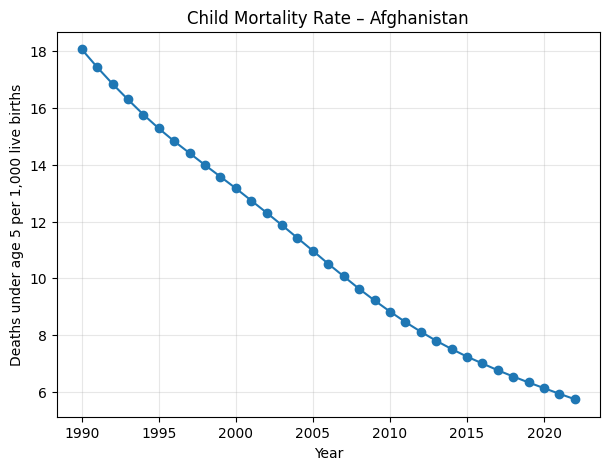

In [ ]:
import matplotlib.pyplot as plt

sample_country = 'Afghanistan'
subset = df[df['country'] == sample_country]

plt.figure(figsize=(7,5))
plt.plot(subset['year'], subset['child_mortality_rate'], marker='o')
plt.title(f'Child Mortality Rate – {sample_country}')
plt.xlabel('Year')
plt.ylabel('Deaths under age 5 per 1,000 live births')
plt.grid(alpha=0.3)
plt.show()


In [9]:
os.makedirs("../data/interim/", exist_ok=True)
df.to_csv(file_out, index=False)
print(f"Cleaned file saved → {file_out}")


Cleaned file saved → ../data/interim/child_mortality_clean.csv
